In [2]:
import sqlite3
from typing import Union, Any
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
graph_track_features = [
    'danceability',
    'energy',
    'loudness',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'duration_ms']

categorical_track_features = [
    'key',
    'mode',
    'time_signature'
]

In [4]:
con = sqlite3.connect('spotify.db')
track_features = pd.read_sql("""SELECT * from songs""", con)
con.close()

In [5]:
track_features.head()

,track_id,analysis_url,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,time_signature,valence
0,37DMXVJ0vZnPZFsc8PejB8,https://api.spotify.com/v1/audio-analysis/37DM...,0.02170,0.711,130107.0,0.521,0.000000,10,0.402,-7.449,0.0580,112.065,4,0.797
1,7nSBHckG4tTFkp0xqNZDs5,https://api.spotify.com/v1/audio-analysis/7nSB...,0.51300,0.506,321503.0,0.714,0.871000,10,0.053,-7.802,0.2910,160.065,4,0.719
2,2eB7JqIY4hTTSz31h6bjwR,https://api.spotify.com/v1/audio-analysis/2eB7...,0.00152,0.153,439120.0,0.953,0.006200,0,0.366,-4.740,0.1220,199.892,4,0.140
3,0WfOuXw05LJq4ik1lVvTzi,https://api.spotify.com/v1/audio-analysis/0WfO...,0.34700,0.819,246507.0,0.599,0.824000,11,0.083,-6.778,0.0390,127.986,4,0.489
4,6n4iuOHAOIu5LtbXBKrD0f,https://api.spotify.com/v1/audio-analysis/6n4i...,0.42600,0.568,190587.0,0.596,0.000097,0,0.130,-6.356,0.0312,120.038,4,0.325


In [6]:
track_features.shape

(999, 14)

In [7]:
track_features.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,time_signature,valence
count,999.000000,999.000000,9.990000e+02,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,0.207633,0.610880,2.086134e+05,0.672427,0.103813,5.312312,0.196613,-7.115352,0.081553,124.922803,3.929930,0.533970
std,0.258459,0.165936,8.398485e+04,0.195008,0.241784,3.572406,0.152954,3.265096,0.075611,27.572372,0.362433,0.243107
min,0.000022,0.065500,4.363400e+04,0.038800,0.000000,0.000000,0.018300,-30.791000,0.023800,61.859000,1.000000,0.029100
25%,0.013700,0.497000,1.619235e+05,0.543000,0.000000,2.000000,0.095000,-8.546500,0.037600,103.039000,4.000000,0.350000
50%,0.084100,0.625000,1.942000e+05,0.703000,0.000131,5.000000,0.130000,-6.511000,0.052800,123.727000,4.000000,0.540000
75%,0.331000,0.737000,2.344145e+05,0.828500,0.026600,8.000000,0.274000,-4.994000,0.089450,143.819500,4.000000,0.719000
max,0.992000,0.966000,1.534720e+06,0.999000,0.973000,11.000000,0.895000,-0.890000,0.523000,205.863000,5.000000,0.980000


In [8]:
track_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          999 non-null    object 
 1   analysis_url      999 non-null    object 
 2   acousticness      999 non-null    float64
 3   danceability      999 non-null    float64
 4   duration_ms       999 non-null    float64
 5   energy            999 non-null    float64
 6   instrumentalness  999 non-null    float64
 7   key               999 non-null    int64  
 8   liveness          999 non-null    float64
 9   loudness          999 non-null    float64
 10  speechiness       999 non-null    float64
 11  tempo             999 non-null    float64
 12  time_signature    999 non-null    int64  
 13  valence           999 non-null    float64
dtypes: float64(10), int64(2), object(2)
memory usage: 109.4+ KB


#### Danceability
Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
#### Energy
Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
#### Key
The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1. >= -1 <= 11
#### Loudness
The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.
#### Mode
Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
#### Speechiness
Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
#### Acousticness
A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
#### Instrumentalness
Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
#### Liveness
Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
#### Valence
A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry). >= 0 <= 1
#### Tempo
The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
#### Type
The type of body. Always "audio features".
#### ID
The Spotify ID for the track.
#### URI
The Spotify URI for the track.
#### Track_href
The URL for the song
#### Analysis_url
A URL to access the full audio analysis of this track. An access token is required to access this data.
#### Duration_ms
The duration of the track in milliseconds.
#### Time_signature
An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4". >= 3 <= 7

In [9]:
dat_graph = track_features[graph_track_features]

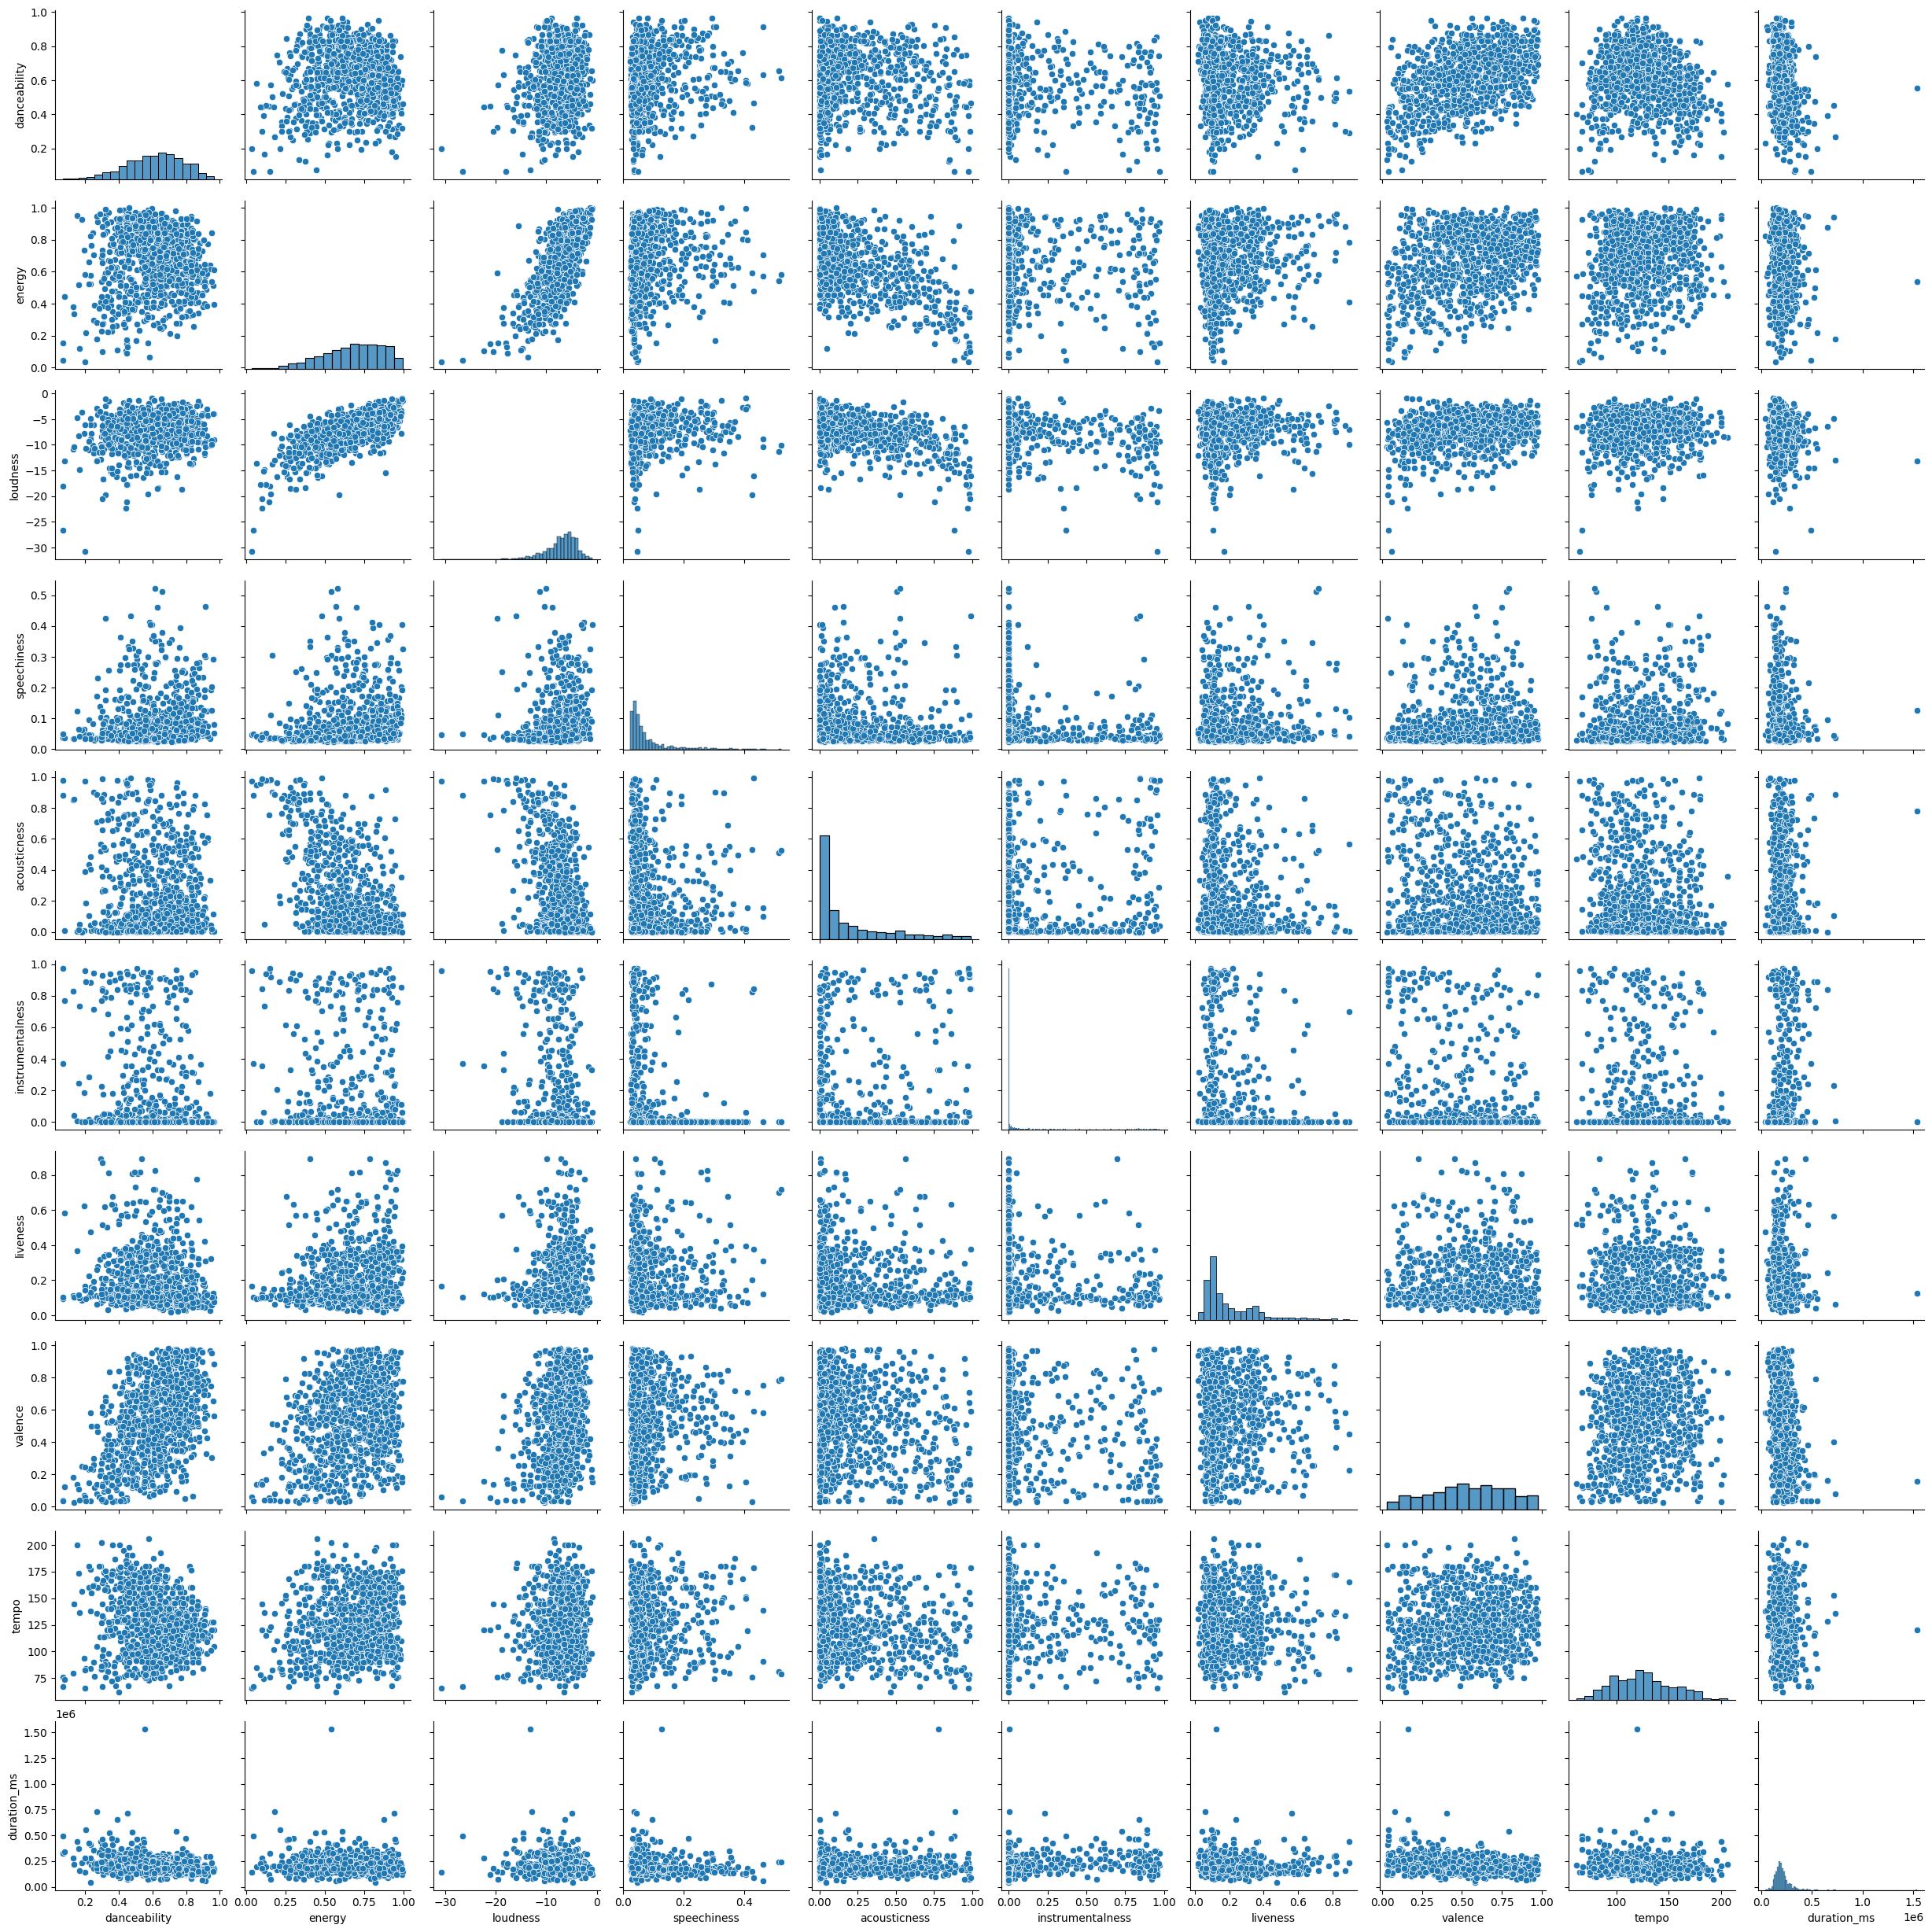

In [10]:
sns.pairplot(dat_graph)
plt.show()

In [11]:
playlist_averages_query="""SELECT o.date, f.fake_name, 
                            AVG(s.acousticness) as avg_acousticness,
                            AVG(s.danceability) as avg_danceability,
                            AVG(s.duration_ms) as avg_duration_ms,
                            AVG(s.energy) as avg_energy,
                            AVG(s.instrumentalness) as avg_instrumentalness,
                            AVG(s.liveness) as avg_liveness,
                            AVG(s.loudness) as avg_loudness,
                            AVG(s.speechiness) as avg_speechiness,
                            AVG(s.tempo) as avg_tempo,
                            AVG(s.valence) as avg_valence
                        FROM owners o 
                        JOIN fake_names f ON o.owner_name=f.owner_name
                        JOIN playlist_songs ps ON o.playlist_id=ps.playlist_id
                        JOIN songs s ON ps.track_id=s.track_id
                        GROUP BY o.owner_name, f.fake_name, o.date
                        ORDER BY date ASC"""

In [12]:
con = sqlite3.connect('spotify.db')
playlist_averages = pd.read_sql(playlist_averages_query,con,parse_dates=['date'])
con.close()

In [13]:
playlist_averages.head()

,date,fake_name,avg_acousticness,avg_danceability,avg_duration_ms,avg_energy,avg_instrumentalness,avg_liveness,avg_loudness,avg_speechiness,avg_tempo,avg_valence
0,2021-12-01,Aurora,0.200619,0.664375,187761.625000,0.679625,0.001987,0.139219,-6.119250,0.086350,132.692187,0.596875
1,2021-12-01,Niamh,0.258561,0.724556,204318.944444,0.645611,0.040657,0.161317,-6.023278,0.088339,133.157000,0.610722
2,2021-12-01,Oliver,0.129464,0.630600,209510.600000,0.719500,0.160003,0.140190,-5.647100,0.082220,117.725600,0.543370
3,2021-12-01,Declan,0.345466,0.516429,284972.476190,0.598333,0.265595,0.174243,-8.539286,0.077876,119.773095,0.312333
4,2022-01-01,Aurora,0.046434,0.611933,195786.400000,0.816200,0.005031,0.197653,-4.624133,0.070287,144.187333,0.665600


In [14]:
playlist_averages.date.dtype

dtype('<M8[ns]')

In [15]:
features_list = ['avg_acousticness',
                'avg_danceability',
                'avg_duration_ms',
                'avg_energy',
                'avg_instrumentalness',
                'avg_liveness',
                'avg_loudness',
                'avg_speechiness',
                'avg_valence']

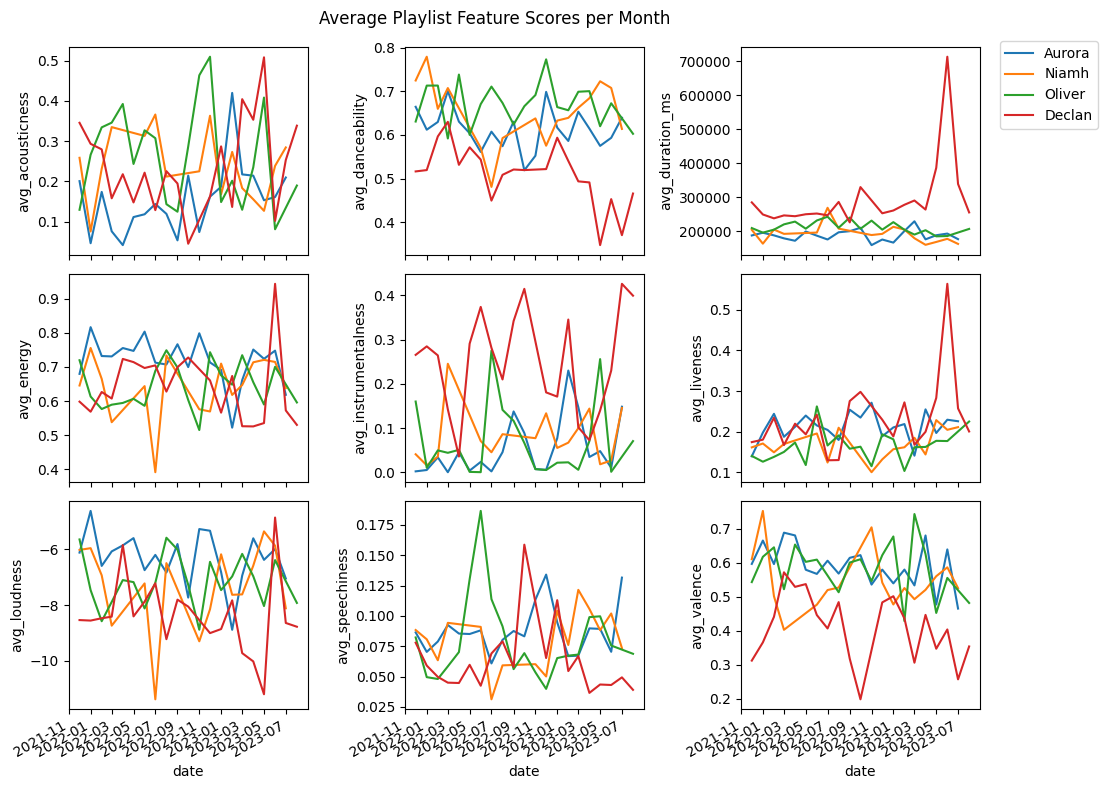

In [16]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10,8))

counter = 0

for i in range(3):
    for j in range(3):
        sns.lineplot(ax=axs[i,j],data=playlist_averages,x='date',y=features_list[counter],hue='fake_name')
        if i == 0 and j == 0: 
            legend = axs[i,j].get_legend()
        axs[i,j].legend().remove()
        axs[i,j].xaxis_date()
        counter += 1

fig.legend(legend.get_lines(),playlist_averages.fake_name.unique(), bbox_to_anchor=(1.11, 0.95))
fig.autofmt_xdate()
fig.suptitle("Average Playlist Feature Scores per Month")
fig.tight_layout()
plt.show()

In [39]:
song_count_query="""SELECT o.playlist_id, 
                        f.fake_name,
                        o.date,
                        COUNT(s.track_id) as n_tracks
                    FROM owners o
                    JOIN fake_names f ON o.owner_name=f.owner_name
                    JOIN playlist_songs ps ON o.playlist_id=ps.playlist_id
                    JOIN songs s ON ps.track_id=s.track_id
                    GROUP BY o.playlist_id
                    """

In [40]:
playlist_averages_query="""SELECT o.date, f.fake_name, 
                            AVG(s.acousticness) as avg_acousticness,
                            AVG(s.danceability) as avg_danceability,
                            AVG(s.duration_ms) as avg_duration_ms,
                            AVG(s.energy) as avg_energy,
                            AVG(s.instrumentalness) as avg_instrumentalness,
                            AVG(s.liveness) as avg_liveness,
                            AVG(s.loudness) as avg_loudness,
                            AVG(s.speechiness) as avg_speechiness,
                            AVG(s.tempo) as avg_tempo,
                            AVG(s.valence) as avg_valence
                        FROM owners o 
                        JOIN fake_names f ON o.owner_name=f.owner_name
                        JOIN playlist_songs ps ON o.playlist_id=ps.playlist_id
                        JOIN songs s ON ps.track_id=s.track_id
                        GROUP BY o.owner_name, f.fake_name, o.date
                        ORDER BY date ASC"""

In [41]:
con = sqlite3.connect('spotify.db')
song_counts = pd.read_sql(song_count_query,con,parse_dates=['date'])
con.close()

In [42]:
song_counts.head()

,playlist_id,fake_name,date,n_tracks
0,016oU3dIRbKKII356tztND,Niamh,2023-04-01,18
1,03ExVxwNx3hoxqyED1Hnbx,Oliver,2022-08-01,22
2,05VbjffmIZGS6Z82gk85lH,Declan,2023-06-01,1
3,0IwXtFXTPvmxrZLZbaH0Ks,Oliver,2023-04-01,19
4,0Nfz9b9QZJIrZHyNPg0ZX7,Oliver,2021-12-01,10


           avg_monthly_tracks
fake_name                    
Aurora              20.850000
Declan              11.200000
Niamh               15.058824
Oliver              12.050000


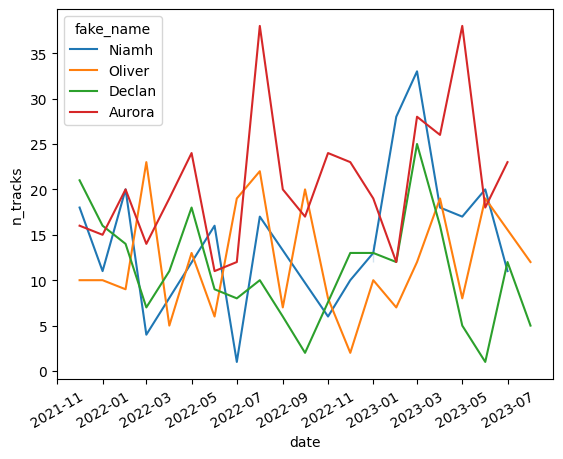

In [57]:
print(song_counts.groupby('fake_name').agg(avg_monthly_tracks = ('n_tracks', np.mean)))

sns.lineplot(song_counts,x='date',y='n_tracks',hue='fake_name')
plt.xticks(rotation=30)
plt.show()